In [52]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import functools
from scipy.stats import poisson

In [53]:
# Generate training data for sales probability regression
def generate_train_data(B=1000, T=100):

    def rank(a, p):
        return np.argsort(np.hstack((a, p)))[:,0]
    
    our_price = np.random.uniform(0, 20, (B, 1))
    competitor_prices = np.random.uniform(0, 20, (B, 5))
    our_rank = np.reshape(rank(our_price, competitor_prices), (B, 1))
    X = np.hstack((our_price, competitor_prices, our_rank))
    
    # Y = (our_rank == 0).astype(int).ravel()
    # Y = np.maximum(0, (3 - our_rank)).astype(int).ravel()
    Y = np.round(np.random.uniform(0, 1, our_rank.shape) * (1 - our_rank / 11)).ravel()
    
    return (X, Y)

X, Y = generate_train_data()

In [54]:
# Train sales probability model
def make_model(X, Y):
    regr = LogisticRegression()
    regr.fit(X, Y)
    def predict(x):
        return regr.predict_proba(x)[:, 1]
    return predict

sales_model = make_model(X, Y)

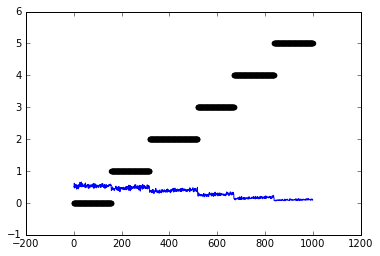

In [55]:
# Plot sales probability model
X_train, _ = generate_train_data(1000)
X_sort = np.sort(X_train.view('f8,f8,f8,f8,f8,f8,f8'), order=['f6'], axis=0).view(float)
plt.scatter(np.arange(0, X_sort.shape[0]), X_sort[:, 6], color='black')
plt.plot(np.arange(0, X_sort.shape[0]), sales_model(X_sort), color='blue', linewidth=1)

plt.show()

In [56]:
# Run Bellmann equation to calculate best price
def optimize_price(t, sales_model, competitor_prices,
               T=5, N=15, 
               price_range=np.arange(0.1, 20, 0.1), 
               L=0.01, delta=0.99, Z=0.5):
#                price_range=np.arange(0.1, 20, 1), 
#                L=0.01, delta=0.99, Z=-5):

    def rank(a, p):
        order = np.argsort(np.hstack((a, p)))
        ranks = np.argsort(order)
        return ranks[0]

    @functools.lru_cache(maxsize=None)
    def sales_prob(price):
        x = np.hstack((price, competitor_prices, rank(price, competitor_prices))).reshape(1, -1)
        return sales_model(x)[0]


    @functools.lru_cache(maxsize=None)
    def _V(price, t, n):
        p = sales_prob(price)
        def mapper(i):
            if i > n:
                return 0
            pi = p if i == 1 else 1 - p
            # pi = poisson.pmf(i, p)
            today_profit = min(n, i) * price
            holding_costs = n * L
            V_future, _ = V(t + 1, max(0, n - i))
            exp_future_profits = delta * V_future
            return pi * (today_profit - holding_costs + exp_future_profits)
        # i_range = range(0, int(poisson.ppf(0.9999, p)) + 1)
        i_range = [0, 1]
        return sum([mapper(i) for i in i_range])

    def V(t, n):
        if t >= T:
            return (n * Z, 0)
        if n <= 0:
            return (0, 0)

        V_values = np.zeros(price_range.shape)
        for i, price in enumerate(price_range):
            v = _V(price, t, n)
            V_values[i] = v 

        V_opt = np.max(V_values)
        price_opt = price_range[np.argmax(V_values)]
        return (price_opt, V_opt)
    
    return V(t, N)

optimize_price(0, sales_model, np.random.uniform(0, 20, 5))

(12.1, 16.206014067073873)

0 5 19.1 0.133151547732 [ 4.6054856   9.36778658  1.25371561  6.3228863   2.65415697] 5
1 5 19.1 0.130490774535 [  4.05446472  10.7736873    1.01312809   6.1625456    2.75593843] 5
2 4 19.1 0.126378683533 [  4.16293642  12.76673852   0.9515862    7.05059362   2.90006883] 5
3 4 19.1 0.130608001403 [  3.61615295  11.00144542   0.77750325   6.45613249   2.54612684] 5
4 4 19.1 0.128994795344 [  3.08035747  11.97740051   0.91072032   6.7159097    2.81954715] 5
5 4 19.1 0.130486465921 [  2.76944368  11.4880214    0.875099     5.82318688   3.17252892] 5
6 4 19.1 0.123481338261 [  3.1148318   13.51622791   0.90208856   5.09793156   2.57889891] 5
7 4 19.1 0.125624709917 [  3.53790527  12.55974626   1.01796341   5.11997817   2.77743235] 5
8 4 19.1 0.121969866235 [  4.23804319  13.608982     1.07288597   5.54672748   2.34694676] 5
9 2 16.1 0.166527594184 [  4.39173737  16.18599085   1.01708824   5.9267605    1.92760205] 4
10 2 14.1 0.163429279654 [  5.21784308  14.86665433   1.11377376   4.823847

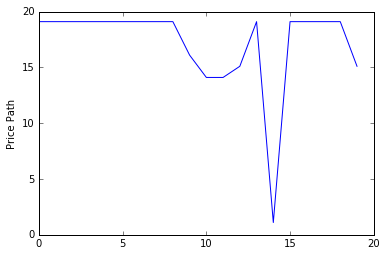

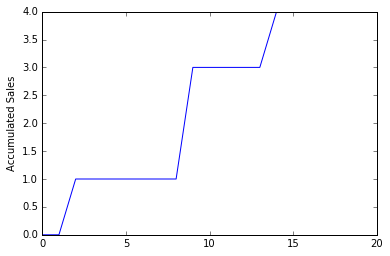

In [57]:
def simulation(sales_model, T=20, N=15):
    competitor_prices = np.random.uniform(0, 20, 5)
    n = N
    
    def rank(a, p):
        order = np.argsort(np.hstack((a, p)))
        ranks = np.argsort(order)
        return ranks[0]
    
    def sales_prob(price):
        x = np.hstack((price, competitor_prices, rank(price, competitor_prices))).reshape(1, -1)
        return sales_model(x)[0]
   
    price_history = []
    accumulated_sales = []

    for t in range(0, T):
        price, _ = optimize_price(t, sales_model, competitor_prices, N=n, T=T)
        price_history.append(price)
        pi = sales_prob(price)
        n = max(0, n - np.random.poisson(pi))
        accumulated_sales.append(N - n)
        print(t, n, price, pi, competitor_prices, rank(price, competitor_prices))
        competitor_prices = competitor_prices * np.random.uniform(0.8, 1.2, 5)
        
    plt.plot(price_history)    
    plt.ylabel('Price Path')
    plt.show()
    
    plt.plot(accumulated_sales)    
    plt.ylabel('Accumulated Sales')
    plt.show()
    
        
            
simulation(sales_model)